# MissOh DataLoader

### AnotherMissOh Visual Structure
- json_data['file_name'] : 'AnotherMissOh01.mp4'
- json_data['visual_results']
- json_data['visual_results'][0].keys() : dict_keys(['start_time', 'end_time', 'vid', 'image_info'])
- {
'start_time': '00:02:51;16', 
'end_time': '00:02:54;15', 
'vid': 'AnotherMissOh01_001_0078', 
'image_info': ...}
- json_data['visual_results'][0]['image_info']
- [{'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004295', 
'place': 'none', 
'persons': [
{'person_id': 'Haeyoung1', 
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 845, 'max_y': 443}, 
'full_rect': {'min_x': 278, 'min_y': 2, 'max_x': 1025, 'max_y': 769}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}], 
'objects': []}, 
- {'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004311', 
'place': '', 
'persons': [{
'person_id':'Haeyoung1',
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 831, 'max_y': 411}, 
'full_rect': {'min_x': 270, 'min_y': 0, 'max_x': 1025, 'max_y': 768}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}],
'objects': []},]

In [1]:
# !apt-get install graphviz xdg-utils

In [2]:
import sys, os
sys.path.append("../") # go to parent dir

In [5]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import pickle
import numpy as np
import glob
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import json
import argparse
import matplotlib.pyplot as plt

from Yolo_v2_pytorch.src.utils import *
from graphviz import Digraph, Graph

ModuleNotFoundError: No module named 'torch'

In [4]:
def is_not_blank(s):
    return bool(s and s.strip())

In [16]:
MissOh_CLASSES = ['person']
print(MissOh_CLASSES[0])
global colors
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))
print(colors[0])

person
(39, 129, 113)


In [17]:
import sys, os
sys.path.append("../") # go to parent dir

In [18]:
import os
import glob
import argparse
import pickle
import cv2
import numpy as np
from Yolo_v2_pytorch.src.utils import *
import torch.nn.functional as F
from torch.utils.data import DataLoader
from Yolo_v2_pytorch.src.yolo_net import Yolo
from Yolo_v2_pytorch.src.anotherMissOh_dataset import AnotherMissOh, Splits, SortFullRect, PersonCLS,PBeHavCLS, FaceCLS, ObjectCLS, P2ORelCLS
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import time

from lib.place_model import place_model, label_mapping, accuracy, label_remapping, place_buffer
from lib.person_model import person_model
from lib.behavior_model import behavior_model
from lib.pytorch_misc import optimistic_restore, de_chunkize, clip_grad_norm, flatten
from lib.focal_loss import FocalLossWithOneHot, FocalLossWithOutOneHot, CELossWithOutOneHot
from lib.face_model import face_model
from lib.object_model import object_model
from lib.relation_model import relation_model
from lib.emotion_model import emotion_model, crop_face_emotion, EmoCLS

num_persons = len(PersonCLS)
num_behaviors = len(PBeHavCLS)
num_faces = len(FaceCLS)
num_objects = len(ObjectCLS)
num_relations = len(P2ORelCLS)
num_emos = len(EmoCLS)

def get_args():
    parser = argparse.ArgumentParser(
        "You Only Look Once: Unified, Real-Time Object Detection")
    parser.add_argument("--image_size",
                        type=int, default=448,
                        help="The common width and height for all images")
    parser.add_argument("--batch_size", type=int, default=1,
                        help="The number of images per batch")
    parser.add_argument("--conf_threshold",
                        type=float, default=0.35)
    parser.add_argument("--nms_threshold",
                        type=float, default=0.5)
    parser.add_argument("--pre_trained_model_type",
                        type=str, choices=["model", "params"],
                        default="model")
    parser.add_argument("--data_path_test",
                        type=str,
                        default="./Yolo_v2_pytorch/missoh_test/",
                        help="the root folder of dataset")

    parser.add_argument("--saved_path", type=str,
                        default="./checkpoint/refined_models")

    parser.add_argument("--img_path", type=str,
                        default="./data/AnotherMissOh/AnotherMissOh_images_ver3.2/")
    parser.add_argument("--json_path", type=str,
                        default="./data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/")
    parser.add_argument("-model", dest='model', type=str, default="baseline")
    parser.add_argument("-display", dest='display', action='store_true')
    parser.add_argument("-emo_net_ch", dest='emo_net_ch',type=int, default=64)
    args = parser.parse_args([])
    return args

# get args.
opt = get_args()
print(opt)

Namespace(batch_size=1, conf_threshold=0.35, data_path_test='./Yolo_v2_pytorch/missoh_test/', display=False, emo_net_ch=64, image_size=448, img_path='./data/AnotherMissOh/AnotherMissOh_images_ver3.2/', json_path='./data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/', model='baseline', nms_threshold=0.5, pre_trained_model_type='model', saved_path='./checkpoint/refined_models')


In [19]:
import networkx as nx
from networkx.drawing.nx_pydot import read_dot
#from networkx.drawing.nx_agraph import read_dot
from networkx.readwrite import json_graph

In [20]:
opt.img_path = "../data/AnotherMissOh/AnotherMissOh_images_ver3.2/"
opt.json_path = "../data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/"
opt.saved_path = "../checkpoint/refined_models"
opt.display = True

In [21]:
tform = [
    Resize((448, 448)),  # should match to Yolo_V2
    ToTensor(),
    # Normalize(# should match to Yolo_V2
    #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
transf = Compose(tform)

# splits the episodes int train, val, test
train, val, test = Splits(num_episodes=18)

# load datasets
train_set = AnotherMissOh(train, opt.img_path, opt.json_path, False)
val_set = AnotherMissOh(val, opt.img_path, opt.json_path, False)
test_set = AnotherMissOh(test, opt.img_path, opt.json_path, False)

episode = 7
infer = [episode]
infer_set = AnotherMissOh(infer, opt.img_path, opt.json_path, False)


# model path
model_path = "{}/anotherMissOh_{}.pth".format(
    opt.saved_path,opt.model)

In [22]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    device = torch.cuda.current_device()
else:
    torch.manual_seed(123)

# set test loader params
test_params = {"batch_size": opt.batch_size,
               "shuffle": False,
               "drop_last": False,
               "collate_fn": custom_collate_fn}

# set test loader
test_loader = DataLoader(infer_set, **test_params)

# ---------------(1) load refined models --------------------
# get the trained models from
# https://drive.google.com/drive/folders/1WXzP8nfXU4l0cNOtSPX9O1qxYH2m6LIp
# define person model
if False:
    # model path
    if False:
        model_path = "../checkpoint/person/anotherMissOh_only_params_{}".format(
            'voc_person_group_1gpu_init_none.pth')
    else:
        model_path = "../checkpoint/person/anotherMissOh_{}".format(
            'voc_person_group_1gpu_init_none.pth')
        
    model_p = person_model(num_persons, device)
    ckpt = torch.load(model_path)
    
    # in case of multi-gpu training
    if False:
        from collections import OrderedDict
        ckpt_state_dict = OrderedDict()
        for k,v in ckpt.items():
            name = k[7:] # remove 'module'
            ckpt_state_dict[name] = v

        print("--- loading {} model---".format(model_path))
        if optimistic_restore(model_p, ckpt_state_dict):
            print("loaded with {}".format(model_path))
    else:
        model_p = ckpt
        print("loaded with {}".format(model_path))
        
    model_p.to(device)
    model_p.eval()

if False :
    print("-----------person---behavior-------model---------------")
    model1 = behavior_model(num_persons, num_behaviors, opt, device)
    trained_persons = '../checkpoint/behavior' + os.sep + "{}".format(
    'anotherMissOh_only_params_integration.pth')
    if optimistic_restore(model1, torch.load(trained_persons)):
        #model1.load_state_dict(torch.load(trained_persons))
        print("loaded with {}".format(trained_persons))

else:
    # pre-trained behavior model
    # step 1: person trained on voc 50 epoch
    # step 2: person feature based behavior sequence learning 100 epoch
    model_p = behavior_model(num_persons, num_behaviors, opt, device)
    if False:
        trained_persons = '../checkpoint/refined_models' + os.sep + "{}".format(
            'anotherMissOh_only_params_integration.pth')
        model_p.load_state_dict(torch.load(trained_persons))
        print("loaded with person and behavior model {}".format(trained_persons))
    else:
        trained_persons = '../checkpoint/behavior' + os.sep + "{}".format(
            'anotherMissOh_voc_person_behavior_new.pth')
        model_p = torch.load(trained_persons)
        print("loaded with person and behavior model {}".format(trained_persons))
        
model_p.cuda(device)
model_p.eval()

# face model
if True:
    model_face = face_model(num_persons, num_faces, device)
    trained_face = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_face.pth')
    model_face.load_state_dict(torch.load(trained_face))
    print("loaded with {}".format(trained_face))
model_face.cuda(device)
model_face.eval()

# emotion model
if True:
    model_emo = emotion_model(opt.emo_net_ch, num_persons, device)
    trained_emotion = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_emotion_integration.pth')
    model_emo.load_state_dict(torch.load(trained_emotion))
    print("loaded with {}".format(trained_emotion))
model_emo.cuda(device)
model_emo.eval()

# object model
if True:
    # add model
    model_object = object_model(num_objects)
    trained_object = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_object_integration.pth')
    # model load
    print("loaded with {}".format(trained_object))
    model_object.load_state_dict(torch.load(trained_object))

model_object.cuda(device)
model_object.eval()


# relation model
if True:
    # add model
    model_relation = relation_model(num_persons, num_objects, num_relations, opt, device)
    trained_relation = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_relation_integration.pth')
    # model load
    print("loaded with {}".format(trained_relation))
    model_relation.load_state_dict(torch.load(trained_relation))
model_relation.cuda(device)
model_relation.eval()

# place model
if True:
    model_place = place_model(num_persons, num_behaviors, device)
    # add model
    trained_place = '../checkpoint/refined_models' + os.sep + "{}".format(
        'anotherMissOh_only_params_place_integration.pth')
    # model load
    print("loaded with {}".format(trained_place))
    model_place.load_state_dict(torch.load(trained_place)['model'])
model_place.cuda(device)
model_place.eval()

True
loaded with person and behavior model ../checkpoint/behavior/anotherMissOh_voc_person_behavior_new.pth
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_face.pth
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_emotion_integration.pth
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_object_integration.pth
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_relation_integration.pth
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_place_integration.pth


place_model(
  (detector): YoloD(
    (stage1_conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (stage1_conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (stage1_conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inpl

In [23]:
# load the color map for detection results
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))

width, height = (1024, 768)
width_ratio = float(opt.image_size) / width
height_ratio = float(opt.image_size) / height

In [24]:
def is_not_blank(s):
    return bool(s and s.strip())

In [25]:
def graph_to_json(episode, scene, frm, info, save_file=None):
    
    if save_file is None:
        save_file = 'temp_graph'
    import string
    strseq = string.ascii_uppercase
    
    # define  graph
    dot = Digraph('G',filename='{}.gv'.format(save_file),engine='fdp')
    dot.attr('graph', rotate = '0', dpi='600',rankdir='TB', size='10,8')
    dot.attr('node', height='0.1', fontsize='6')
    dot.attr('edge', fontsize='6')

    place = "{}".format(info['place'])
    sound = "{}".format(info['sound'])

    if not is_not_blank(place):
        place = 'none'
    if not is_not_blank(sound):
        sound = 'none'

    num_of_persons = len(info['persons'])
    num_of_objects = len(info['objects'])

    frm_graph = 'episode_{}_scene_{}_frame_{}'.format(
        episode, scene, frm)

    #dot.node(frm_graph, style='filled', color='lightgrey')
    episode_node = "episode_{:02d}".format(episode)
    scene_node = "scene_{:03d}".format(scene)
    frame_node = "frame_{:04d}".format(frm)
    dot.node(episode_node, style='filled', color='lightgrey')
    dot.node(scene_node, style='filled', color='lightgrey')
    dot.node(frame_node, style='filled', color='lightgrey')

    # backgrounds--------------------------------------------
    dot.node(place, style='filled', color='lightblue')
    dot.node(sound, style='filled', color='lightblue')
    
    if is_not_blank(episode_node) and is_not_blank(scene_node):
        dot.edge(episode_node, scene_node)

    if is_not_blank(scene_node) and is_not_blank(frame_node):
        dot.edge(scene_node, frame_node)

    if is_not_blank(frame_node) and is_not_blank(place):
        dot.edge(frame_node, place)

    if is_not_blank(frame_node) and is_not_blank(sound):
        dot.edge(frame_node, sound)
    
    # person ------------------------------------------------
    for person_id in info['persons'].keys():

        if is_not_blank(person_id):
            dot.node(person_id)

        # behavior---
        if 'behavior' in info['persons'][person_id].keys():
            behavior_id = info['persons'][person_id]['behavior']
        else:
            behavior_id = 'none'
        if is_not_blank(behavior_id):
            dot.node(behavior_id, style='filled', color='green')

        # emotion---
        if 'emotion' in info['persons'][person_id].keys():
            emotion_id = info['persons'][person_id]['emotion']
        else:
            emotion_id = 'none'
        if is_not_blank(emotion_id):
            dot.node(emotion_id, style='filled', color='blue')

        if is_not_blank(frame_node) and is_not_blank(person_id):
            dot.edge(frame_node, person_id)

        if is_not_blank(person_id) and is_not_blank(behavior_id):
            dot.edge(person_id, behavior_id)

        if is_not_blank(person_id) and is_not_blank(emotion_id):
            dot.edge(person_id, emotion_id)
    
    # relation ---------------------------------------------
    for object_id in info['objects'].keys():
        if is_not_blank(object_id):
            dot.node(object_id, style='filled', color='gold')

    for person_id in info['relations'].keys():
        if person_id not in info['persons'].keys():
            dot.node(person_id)
            dot.edge(frame_node, person_id)
            
        for object_id in info['relations'][person_id].keys() :
            if object_id not in info['objects'].keys():
                dot.node(object_id)
                dot.edge(frame_node, object_id)
            predicate = info['relations'][person_id][object_id]
            dot.edge(person_id, object_id,label=predicate, color='red')

    # convert dot graph to json
    if False:
        dot_to_json =json.dumps(json_graph.node_link_data(dot))
    else:
        dot_to_json = json.dumps(info)
    
    with open('{}.json'.format(save_file), 'w') as f:
        json.dump(dot_to_json, f)
        
    # show in image
    dot.format = 'png'
    dot.render('{}.gv'.format(save_file), view=True) 
   
    graph = cv2.imread('{}.gv.png'.format(save_file))
    graph = cv2.resize(graph, dsize=(0, 0), fx=600.0/graph.shape[0], fy=600.0/graph.shape[0])
     
    if True:
        plt.figure(figsize=(10,10))
        plt.imshow(graph)
        plt.show()
        plt.close()

{'persons': {'Haeyoung1': {'emotion': 'happy', 'behavior': 'talking'}, 'Deogi': {'emotion': 'happy', 'behavior': 'eating'}}, 'objects': {'spoon': {'Deogi': 'N_R'}}, 'relations': {'Deogi': {'spoon': 'holding'}}, 'place': 'kitchen', 'sound': 'talking'}


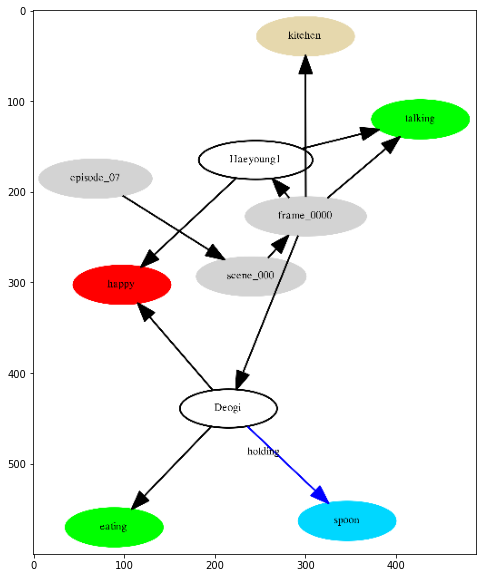

In [26]:
clip = 0
frm = 0

#---------------graph structure--------------------------
graph_json = {}
graph_json['persons'] = {}
graph_json['objects'] = {}
graph_json['relations'] = {}

# ---------------persons---------------------------------
graph_json['persons']['Haeyoung1'] = {}
graph_json['persons']['Haeyoung1']['emotion'] = 'happy'
graph_json['persons']['Haeyoung1']['behavior'] = 'talking'
graph_json['persons']['Deogi'] = {}
graph_json['persons']['Deogi']['emotion'] = 'happy'
graph_json['persons']['Deogi']['behavior'] = 'eating'

# ---------------objects---------------------------------
graph_json['objects']['spoon'] = {}
graph_json['objects']['spoon']['Deogi'] = 'N_R'

# ---------------Relations-------------------------------
graph_json['relations']['Deogi'] = {}
graph_json['relations']['Deogi']['spoon'] = 'holding'

# ---------------Backgrounds-----------------------------
graph_json['place'] = 'kitchen'
graph_json['sound'] = 'talking'

info = graph_json
print(info)

graph_to_json(episode, clip, frm, graph_json)

In [27]:
# Sequence buffers
buffer_images = []
graph_info = {}
# load test clips
for iter, batch in enumerate(test_loader):
    image, info = batch

    scene = iter
    episode = episode
    
    # sort label info on fullrect
    image, label, behavior_label, obj_label, face_label, emo_label, frame_id = SortFullRect(
        image, info, is_train=False)

    try :
        image = torch.cat(image,0).cuda(device)
    except:
        continue

    # -----------------(2) inference -------------------------
    # person and behavior predictions
    # person
    # logits : [1, 125, 14, 14]
    if False:
        p_logits, _ = model_p(image)
        predictions_p = post_processing(p_logits,
                                        opt.image_size,
                                        PersonCLS,
                                        model_p.detector.anchors,
                                        opt.conf_threshold,
                                        opt.nms_threshold)
    
    # logits : [1, 125, 14, 14]
    # behavior_logits : [1, 135, 14, 14]
    else :
        predictions_p, b_logits = model_p(image, label, behavior_label)

    # face
    if np.array(face_label).size > 0 :
        face_logits = model_face(image)
        predictions_face = post_processing(face_logits,
                                           opt.image_size,
                                           FaceCLS,
                                           model_face.detector.anchors,
                                           opt.conf_threshold,
                                           opt.nms_threshold)

    # object
    if np.array(obj_label).size > 0 :
        object_logits, _ = model_object(image)

        predictions_object = post_processing(object_logits,
                                             opt.image_size,
                                             ObjectCLS,
                                             model_object.detector.anchors,
                                             opt.conf_threshold,
                                             opt.nms_threshold)
        
    # relation
    if np.array(obj_label).size > 0 and np.array(label).size > 0:
        r_preds, r_obj_preds, relation_predictions = model_relation(image, label, obj_label)


    # place
    images_norm = []; info_place = []; preds_place = []
    for idx in range(len(image)):
        image_resize = image[idx]
        images_norm.append(image_resize)
        info_place.append(info[0][idx]['place'])
        frame_place = frame_id.copy()
    info_place = label_mapping(info_place)
    buffer_images = place_buffer(images_norm, buffer_images)
    pl_updated=False
    buffer_idx = 10 - (len(images_norm) %10)
    images_norm = buffer_images[-buffer_idx:] + images_norm
    for plidx in range(len(images_norm)//10):
        batch_images = torch.stack(images_norm[plidx*10:(plidx+1)*10]).cuda(device).unsqueeze(0)
        output = model_place(batch_images)
        output = torch.cat((output[:, :9], output[:, 10:]), 1) # None excluded. For None prediction, comment this line out.
        preds = torch.argmax(output, -1).tolist() # (T, n_class) ->(T, )
        for idx in range(len(preds)):
            if preds[idx] >= 9: preds[idx] += 1
        preds_place += preds;
        pl_updated = True
    buffer_images = images_norm[-10:]
    preds_place = preds_place[buffer_idx:]
    assert len(preds_place) == len(info_place)
    preds_place_txt = label_remapping(preds_place)
    target_place_txt = label_remapping(info_place)
    
    for idx, frame in enumerate(frame_id):
        
        # ---------------(3) mkdir for evaluations----------------------
        f_info = frame[0].split('/')
        save_dir = '../results/drama-graph/{}/{}/{}/'.format(
            f_info[4], f_info[5], f_info[6])
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        f_file = f_info[7]
        mAP_file = "{}_{}_{}_{}".format(f_info[4],
                                        f_info[5],
                                        f_info[6],
                                        f_info[7].replace("jpg", "txt"))
        if opt.display:
            # AnotherMissOh07_002_0036_IMAGE_0000002672.txt
            print("frame.__len__{}, mAP_file:{}".format(len(frame_id), mAP_file))
            
        # --------------(5) visualization of inferences ----------
        # out of try : pdb.set_trace = lambda : None
        try:
            # for some empty video clips
            img = image[idx]
            # ToTensor function normalizes image pixel values into [0,1]
            np_img = img.cpu().numpy()
            np_img = np.transpose(np_img,(1,2,0)) * 255
            output_image = cv2.cvtColor(np_img,cv2.COLOR_RGB2BGR)
            output_image = cv2.resize(output_image, (width, height))
            
            #**************************************
            graph_json = {}
            graph_json['persons'] = {}
            graph_json['objects'] = {}
            graph_json['relations'] = {}
            graph_json['sound'] = 'none'
            #**************************************
            
            # face
            if len(predictions_face) != 0:
                prediction_face = predictions_face[idx]
                for pred in prediction_face:
                    xmin = int(max(pred[0] / width_ratio, 0))
                    ymin = int(max(pred[1] / height_ratio, 0))
                    xmax = int(min((pred[2]) / width_ratio, width))
                    ymax = int(min((pred[3]) / height_ratio, height))
                    color = colors[FaceCLS.index(pred[5])]
                    
                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)
                    text_size = cv2.getTextSize(
                        pred[5] + ' : %.2f' % pred[4],
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % pred[4],
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)
                    
                    # save detection results
                    pred_cls = pred[5]
                    cat_pred = '%s %s %s %s %s %s\n' % (
                        pred_cls,
                        str(pred[4]),
                        str(xmin), str(ymin), str(xmax), str(ymax))
                    
                    print("face_pred:{}".format(cat_pred))
                    print("detected {}".format(
                        save_dir + "{}".format(f_file)))
                    
                    #**************************************************
                    graph_json['persons'][pred_cls] = {}
                    #**************************************************
                    
                    # update emotion model and the prediction
                    if False:
                        fl = face_label[idx][jdx]
                        face_x0, face_y0 = int(fl[0]/width_ratio), int(fl[1]/height_ratio)
                        face_x1, face_y1 = int(fl[2]/width_ratio), int(fl[3]/height_ratio)
                        
                        
                        # emotion
                        if np.array(face_label).size > 0 and False:
                            face_label = [fl for fl in face_label if len(fl) > 0]
                            emo_label = [el for el in emo_label if len(el) > 0]
                            image_c = image.permute(0,2,3,1).cpu()
                            face_crops, emo_gt = crop_face_emotion(image_c, face_label, emo_label, opt)
                            face_crops, emo_gt = face_crops.cuda(device).contiguous(), emo_gt.cuda(device)
                            emo_logits = model_emo(face_crops)
                            num_img, num_face = np.array(face_label).shape[0:2]
                            emo_logits = emo_logits.view(num_img, num_face, 7)
                        
                        
                        emo_ij = F.softmax(emo_logits[idx,jdx,:], dim=0).argmax().detach().cpu().numpy()
                        emo_txt = EmoCLS[emo_ij]
                        cv2.rectangle(output_image, (face_x0,face_y0),
                                      (face_x1,face_y1), (255,255,0), 1)
                        cv2.putText(output_image, emo_txt, (face_x0, face_y0-5),
                                    cv2.FONT_HERSHEY_PLAIN, 1, (255,255,0), 1,
                                    cv2.LINE_AA)
                        
                        #******************************************************
                        graph_json['persons'][pred_cls]['emotion'] = emo_txt
                        #******************************************************
                    
            else:
                print("non-detected {}".format(
                        save_dir + "{}".format(f_file)))
            

            if len(predictions_p) != 0 :
                prediction = predictions_p[idx]
                
                if True:
                    b_logit = b_logits[idx]

                # person and behavior
                num_preds = len(prediction)
                                
                for jdx, pred in enumerate(prediction):
                    # person
                    xmin = int(max(pred[0] / width_ratio, 0))
                    ymin = int(max(pred[1] / height_ratio, 0))
                    xmax = int(min((pred[2]) / width_ratio, width))
                    ymax = int(min((pred[3]) / height_ratio, height))
                    color = colors[PersonCLS.index(pred[5])]

                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)
                    
                    text_size = cv2.getTextSize(
                        pred[5] + ' : %.2f' % pred[4],
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % pred[4],
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)
                        
                    pred_cls = pred[5]
                    cat_pred = '%s %s %s %s %s %s\n' % (
                        pred_cls,
                        str(pred[4]),
                        str(xmin), str(ymin), str(xmax), str(ymax))
                    print("person_pred:{}".format(cat_pred))
                    
                    #**************************************************
                    if pred_cls not in graph_json['persons'].keys():
                        graph_json['persons'][pred_cls] = {}
                    #**************************************************
                    
                    # behavior
                    if True:
                        value, index = b_logit[jdx].max(0)

                        b_idx = index.cpu().numpy()
                        b_pred = PBeHavCLS[b_idx]
                        
                        cv2.putText(
                            output_image, '+ behavior : ' + b_pred,
                            (xmin, ymin + text_size[1] + 4 + 12),
                            cv2.FONT_HERSHEY_PLAIN, 1,
                            (255, 255, 255), 1)
                        pred_beh_cls = b_pred.replace(' ', '_')
                        pred_beh_cls = pred_beh_cls.replace('/', '_')
                        
                        #******************************************************
                        graph_json['persons'][pred_cls]['behavior'] = pred_beh_cls
                        #******************************************************
                        
                        cat_pred_beh = '%s %s %s %s %s %s\n' % (
                            pred_beh_cls,
                            str(pred[4]),
                            str(xmin), str(ymin), str(xmax), str(ymax))

                        print("behavior_pred:{}".format(cat_pred_beh))
                    
                    if opt.display:
                        print("detected {}".format(save_dir + "{}".format(f_file)))
                else:
                    if opt.display:
                        print("non-detected {}".format(
                        save_dir + "{}".format(f_file)))

            # object
            if len(predictions_object) != 0:
                
                prediction_object = predictions_object[0]
                num_preds = len(prediction)
                for jdx, pred in enumerate(prediction_object):
                    xmin = int(max(pred[0] / width_ratio, 0))
                    ymin = int(max(pred[1] / height_ratio, 0))
                    xmax = int(min((pred[2]) / width_ratio, width))
                    ymax = int(min((pred[3]) / height_ratio, height))
                    color = colors[ObjectCLS.index(pred[5])]

                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)

                    text_size = cv2.getTextSize(
                        pred[5] + ' : %.2f' % pred[4],
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % pred[4],
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)

                    # save detection results
                    pred_obj_cls = pred[5]
                    cat_pred = '%s %s %s %s %s %s\n' % (
                        pred_obj_cls,
                        str(pred[4]),
                        str(xmin), str(ymin), str(xmax), str(ymax))
                    
                    #**************************************************
                    graph_json['objects'][pred_obj_cls] = {}
                    #**************************************************
                    print("object_pred:{}".format(cat_pred))

                    if opt.display:
                        print("detected {}".format(
                            save_dir + "{}".format(f_file)))
                else:
                    if opt.display:
                        print("non-detected {}".format(
                        save_dir + "{}".format(f_file)))
                        
            # relation
            if len(r_preds) != 0:
                r_pred = r_preds[idx]
                r_obj_pred = r_obj_preds[idx]
                relation_prediction = relation_predictions[idx]
                num_preds = len(r_pred)
                for jdx, pred in enumerate(r_pred):
                    xmin = int(max(float(pred[0]) / width_ratio, 0))
                    ymin = int(max(float(pred[1]) / height_ratio, 0))
                    xmax = int(min((float(pred[2])) / width_ratio, width))
                    ymax = int(min((float(pred[3])) / height_ratio, height))
                    color = colors[PersonCLS.index(pred[5])]
                    
                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)
                    
                    pred_per_cls = pred[5]
                    text_size = cv2.getTextSize(
                        pred_per_cls + ' : %.2f' % float(pred[4]),
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % float(pred[4]),
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)
                    
                    #*****************************************************
                    graph_json['relations'][pred_per_cls] = {}
                    #*****************************************************

                    for kdx, obj_pred in enumerate(r_obj_pred):
                        xmin = int(max(float(obj_pred[0]) / width_ratio, 0))
                        ymin = int(max(float(obj_pred[1]) / height_ratio, 0))
                        xmax = int(min((float(obj_pred[2])) / width_ratio, width))
                        ymax = int(min((float(obj_pred[3])) / height_ratio, height))

                        color = colors[ObjectCLS.index(obj_pred[5])]
                        cv2.rectangle(output_image, (xmin, ymin), (xmax, ymax), color, 2)
                        
                        pred_obj_cls = obj_pred[5]
                        text_size = cv2.getTextSize(
                            pred_obj_cls + ' : %.2f' % float(obj_pred[4]),
                            cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                        cv2.rectangle(
                            output_image,
                            (xmin, ymin),
                            (xmin + text_size[0] + 100,
                             ymin + text_size[1] + 20), color, -1)
                        cv2.putText(
                            output_image, obj_pred[5] + ' : %.2f' % float(obj_pred[4]),
                            (xmin, ymin + text_size[1] + 4),
                            cv2.FONT_HERSHEY_PLAIN, 1,
                            (255, 255, 255), 1)
                        
                        value, ind = relation_prediction[kdx].max(1)
                        ind = int(ind.cpu().numpy())
                        rel_ind = P2ORelCLS[ind]
                        cv2.putText(
                            output_image, '+ relation : ' + rel_ind,
                            (xmin, ymin + text_size[1] + 4 + 12),
                            cv2.FONT_HERSHEY_PLAIN, 1,
                            (255, 255, 255), 1)

                        pred_pred_cls = rel_ind
                        cat_pred = '%s %s %s %s %s\n' % (
                            pred_cls, str(xmin), str(ymin), str(xmax), str(ymax))
                        print("relation_pred:{}".format(cat_pred))
                        
                        #*****************************************************
                        graph_json['relations'][pred_per_cls][pred_obj_cls] = pred_pred_cls
                        #*****************************************************
                        
            # place
            if len(preds_place_txt) != 0:
                cv2.putText(output_image, "place : " + preds_place_txt[idx],
                    (30, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
                
                #*****************************************
                graph_json['place'] = preds_place_txt[idx]
                #*****************************************
                
                if opt.display:
                    print('place_pred :', preds_place_txt[idx])
                
                
            # save output image  
            cv2.imwrite(save_dir + "{}".format(f_file), output_image)
            # save images
            plt_output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(8,8))
            plt.imshow(plt_output_image.astype('uint8'))
            plt.show()
            plt.close()
            
            #*****************************************
            frm_name = "episode_{:02d}_scene_{:03d}_frame_{:04d}".format(episode, scene, idx)
            save_file = save_dir + frm_name
            print(graph_json)
            graph_to_json(episode, scene, idx, graph_json, save_file)
            #*****************************************
        except:
            continue

/usr/local/envs/vtt_env/lib/python3.6/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/envs/vtt_env/lib/python3.6/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002446.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002454.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002462.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002470.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002478.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002486.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002494.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002502.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002510.txt
frame.__len__10, mAP_file:AnotherMissOh07_001_0035_IMAGE_0000002518.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002576.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002584.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002592.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002

KeyboardInterrupt: 